## Generate 3D and 2D points, Mint and Mext

### Generate 32 points from 2 surfaces on a cube

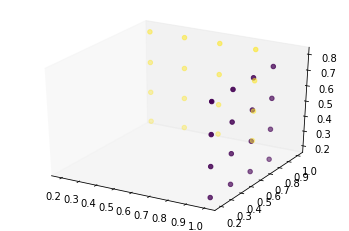

In [1]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


cnt = 0
P_w = np.zeros((32, 3))
#surface Xw=1
for i in np.linspace(0.2, 0.8, 4):
  for j in np.linspace(0.2, 0.8, 4):
    P_w[cnt, :] = np.array([[1, i, j]])
    cnt+=1
#surface Yw=1
for i in np.linspace(0.2, 0.8, 4):
  for j in np.linspace(0.2, 0.8, 4):
    P_w[cnt, :] = np.array([[i, 1, j]])
    cnt+=1

x=P_w[:,0]
y=P_w[:,1]
z=P_w[:,2]
colors = [0 for i in range(16)] + [1 for i in range(16)] # Xw=1:purple, Yw=1:yellow
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
pnt3d=ax.scatter(x,y,z,c=colors)
plt.show()

### Extrinsic parameters

In [2]:
# Rotation matrix R = RaRbRr
alpha = -120*np.pi/180
R_alpha = np.array([[1, 0, 0],
         [0, np.cos(alpha), -np.sin(alpha)],
         [0, np.sin(alpha), np.cos(alpha)]])

beta = 0*np.pi/180
R_beta = np.array([[np.cos(beta), 0, -np.sin(beta)],
         [0, 1, 0],
         [np.sin(beta), 0, np.cos(beta)]])

gamma = 40*np.pi/180
R_gamma = np.array([[np.cos(gamma), -np.sin(gamma), 0],
         [np.sin(gamma), np.cos(gamma), 0],
         [0, 0, 1]])
print(alpha, beta, gamma)
R = np.dot(np.dot(R_alpha,R_beta),R_gamma)
R

-2.0943951023931953 0.0 0.6981317007977318


array([[ 0.76604444, -0.64278761,  0.        ],
       [-0.3213938 , -0.38302222,  0.8660254 ],
       [-0.5566704 , -0.66341395, -0.5       ]])

In [3]:
# Translation matrix
Tr = np.array([[0,0,4]]).T
Tx, Ty, Tz = Tr

### Intrinsic parameters

In [4]:
#focal length
f = 0.016;

#image center
Ox = 256;
Oy = 256;

#pixel size of image sensor
Sx = 0.0088/512.0;
Sy = 0.0066/512.0;

#effective focal length
Fx = f/Sx;
Fy = f/Sy;

#aspect ratio
aspr = Fx/Fy

print(Sx, Sy, Fx, Fy, aspr)

1.71875e-05 1.2890625e-05 930.9090909090909 1241.2121212121212 0.75


### print all

In [5]:

print('\nDesigned intrinsic parameters:')
print("Image center used to estimate is:", (Ox, Oy))
print('\nFx and Fy:', (Fx, Fy))
print('\nAspect ratio:', aspr)
print('\nDesigned extrinsic parameters:')
print('\nR:', R)
print('\nTx:', Tx)
print('\nTy:', Ty)
print('\nTz:', Tz)
print('\nalpha:', alpha)
print('\nbeta:', beta)
print('\ngamma:', gamma)


Designed intrinsic parameters:
Image center used to estimate is: (256, 256)

Fx and Fy: (930.9090909090909, 1241.2121212121212)

Aspect ratio: 0.75

Designed extrinsic parameters:

R: [[ 0.76604444 -0.64278761  0.        ]
 [-0.3213938  -0.38302222  0.8660254 ]
 [-0.5566704  -0.66341395 -0.5       ]]

Tx: [0]

Ty: [0]

Tz: [4]

alpha: -2.0943951023931953

beta: 0.0

gamma: 0.6981317007977318


### Generate 2D points on camera image coordinate

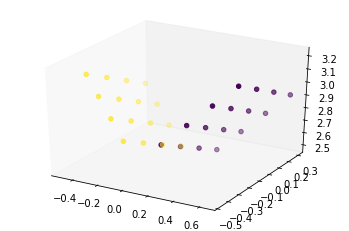

In [6]:
# surface Xw = 1

P_c = np.zeros((32,3))
p_ = np.zeros((32, 2))
p = np.zeros((32,2))


for cnt in range(32):
  P_c[cnt,:] = (np.resize(np.dot(R,(P_w[cnt].T)), (3,1)) + Tr).T
  p_[cnt,:] = np.array([[Ox - np.dot(Fx, P_c[cnt, 0]/P_c[cnt, 2]), Oy - np.dot(Fy, P_c[cnt, 1]/P_c[cnt, 2])]])  
  p[cnt,:] = np.array([[Ox - np.dot(Fx, P_c[cnt, 0]/P_c[cnt, 2]) - Ox, Oy - np.dot(Fy, P_c[cnt, 1]/P_c[cnt, 2]) - Oy]])   

# plot camera 3D points
x=P_c[:,0]
y=P_c[:,1]
z=P_c[:,2]
colors = [0 for i in range(16)] + [1 for i in range(16)] # Xw=1:purple, Yw=1:yellow
fig_3 = plt.figure()
ax = fig_3.add_subplot(111, projection='3d')
ax.grid(False)
pnt3d=ax.scatter(x,y,z,c=colors)
plt.show()

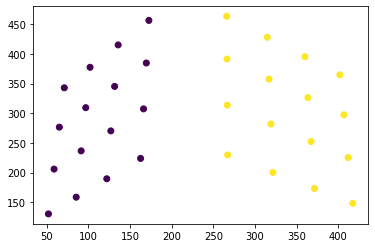

In [7]:
#plot 2d points in camera coordinate system
colors = [0 for i in range(16)] + [1 for i in range(16)]
fig_2d = plt.scatter(p_[:, 0], p_[:, 1], c = colors)
plt.show()

## Camera Calibration Algorithm - Estimate camera parameters

In [59]:
from numpy import linalg
import math

class CameraCalibration:
  def __init__(self, p, P_w):
    self.p = p
    self.P_w = P_w
    self.x, self.X, self.y, self.Y, self.Z = self.p[:,0], self.P_w[:,0], self.p[:,1], self.P_w[:,1], self.P_w[:,2]
    self.A = np.zeros((32,8))
    self.A[:, 0] = np.array([self.x[i]*self.X[i] for i in range(32)]).T
    self.A[:, 1] = np.array([self.x[i]*self.Y[i] for i in range(32)]).T
    self.A[:, 2] = np.array([self.x[i]*self.Z[i] for i in range(32)]).T
    self.A[:, 3] = np.array([self.x[i] for i in range(32)]).T
    self.A[:, 4] = np.array([-self.y[i]*self.X[i] for i in range(32)]).T
    self.A[:, 5] = np.array([-self.y[i]*self.Y[i] for i in range(32)]).T
    self.A[:, 6] = np.array([-self.y[i]*self.Z[i] for i in range(32)]).T
    self.A[:, 7] = np.array([-self.y[i] for i in range(32)]).T

    self.solution_v = None


  def solution_vector(self):
    U, lambdas, V = linalg.svd(self.A)
    self.solution_v = V[-1,:]
    return self.solution_v

  def scale_factor_aspr(self):
    scale_factor = np.sqrt(self.solution_v[0]**2 + self.solution_v[1]**2 + self.solution_v[2]**2) #absolute value
    aspr = np.sqrt(self.solution_v[4]**2 + self.solution_v[5]**2 + self.solution_v[6]**2)/scale_factor
    return scale_factor, aspr

  def Tx_Ty(self, scale_factor, aspr):
    self.solution_v = self.solution_v/scale_factor
    Ty = self.solution_v[3]
    Tx = self.solution_v[-1]/aspr
    return Tx, Ty

  def R_matrix(self, aspr, R = None, Tx = None, sign = None):
    if sign == None:
      s = 1
    else:
      s = sign #assume it's a positive sign first
    R = np.zeros((3,3))
    r11, r12, r13 = [s*self.solution_v[i]/aspr for i in range(4,7)]
    r21, r22, r23 = [s*self.solution_v[i] for i in range(0,3)]
    R_1 = np.array([[r11, r12, r13]])
    R_2 = np.array([[r21, r22, r23]])
    R_3 = np.cross(s*R_1, s*R_2)
    r31, r32, r33 = [value for value in R_3[0]]
    R[0, :] = R_1
    R[1, :] = R_2
    R[2, :] = R_3
    # Enforece orthogonal constraint - Use SVD of estimate R 
    U, D, V = np.linalg.svd(R)
    R = U.dot(np.diag(D)).dot(V.T)
    return R

  def determine_sign(self, R, Tx):
    self.X = R[0,:].dot(self.P_w[0]) + Tx
    if np.sign(self.p[0][0]) != np.sign(self.X):
      s = -1
    else:
      s = 1
    self.solution_v = s*self.solution_v
    return s

  def R_angles(self, R):
  #Estimate alpha beta and gamma of R matrix
    gamma = math.atan2(-R[0][1], R[0][0])
    beta = math.atan2(R[0][2], np.sqrt(R[0][1]**2 + R[0][0]**2))
    alpha = math.atan2(-R[1][2], R[2][2])
    return alpha, beta, gamma

  def Tz_fx(self, R, Tx):
    #calculate right side
    ai2 = [sum(row) for row in R[0,:]*self.P_w + Tx]
    ai1 = self.p[:, 0].tolist()
    A_2 = np.array([ai1, ai2]).T
    bi = np.array([sum(row) for row in R[2,:]*self.P_w])
    b = -np.array(ai1) * bi
    right = np.dot(A_2.T, b)
    #calculate left side
    A_3 = A_2.T.dot(A_2)
    U_2, lambdas_2, V_2 = np.linalg.svd(A_3)
    left = np.dot(np.dot(V_2.T, np.linalg.inv(np.diag(lambdas_2))), U_2.T)
    #calculate Tz and effective focal length fx
    Tz_fx = np.dot(left, right)
    return Tz_fx[0], Tz_fx[1]


In [61]:
my_results = CameraCalibration(p, P_w)
A_matrix = my_results.A
solution_vector = my_results.solution_vector()
sf, aspr = my_results.scale_factor_aspr()
Tx, Ty = my_results.Tx_Ty(sf, aspr)
initial_R = my_results.R_matrix(aspr, R = None, Tx = None, sign = None)
sign = my_results.determine_sign(initial_R, Tx)
updated_R = my_results.R_matrix(aspr, R = initial_R, Tx = Tx, sign = sign)
alpha, beta, gamme = my_results.R_angles(updated_R)
Tz, fx = my_results.Tz_fx(updated_R, Tx)
fy = fx/aspr

## Print all results 

In [62]:
print('\nEstimated intrinsic parameters:')
print("Known image center used to estimate is:", (Ox, Oy))
print('\nFx and Fy:', (fx, fy))
print('\nAspect ratio:', aspr)
print('\nEstimated extrinsic parameters:')
print('\nR:', updated_R)
print('\nTx:', Tx)
print('\nTy:', Ty)
print('\nTz:', Tz)
print('\nalpha:', alpha)
print('\nbeta:', beta)
print('\ngamma:', gamma)


Estimated intrinsic parameters:
Known image center used to estimate is: (256, 256)

Fx and Fy: (32.13222120808736, 42.842961610783206)

Aspect ratio: 0.7499999999999989

Estimated extrinsic parameters:

R: [[-7.66044443e-01 -6.42787610e-01 -1.04405412e-16]
 [ 3.21393805e-01 -3.83022222e-01  8.66025404e-01]
 [-5.56670399e-01  6.63413948e-01  5.00000000e-01]]

Tx: 1.1000297330811479e-16

Ty: -1.687196700334526e-15

Tz: -0.2782896252505923

alpha: -1.0471975511965963

beta: -1.0440541215798755e-16

gamma: 0.6981317007977318
